In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

def prepare_data(ds):
 ds = ds.map(lambda img, target: (tf.reshape(img, (-1,)), target))
 ds = ds.map(lambda image, label: ((tf.cast(image, tf.float32)/128)-1, label))
 ds = ds.map(lambda image, label: (image, tf.one_hot(label, depth=10)))
 ds = ds.shuffle(1024).batch(32)
 ds = ds.prefetch(4)
 return ds

train_dataset = train_ds.apply(prepare_data)
test_dataset = test_ds.apply(prepare_data)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [2]:
class MLP_Model(tf.keras.Model):
  def __init__(self, layer_sizes, output_size=10):
    super().__init__()
    self.mlp_layers = []
    #layzer size e.g. [256, 256]
    for layer_size in layer_sizes:
      new_layer = tf.keras.layers.Dense(units=layer_size, activation='sigmoid')
      self.mlp_layers.append(new_layer)
    self.output_layer = tf.keras.layers.Dense(units=output_size, activation="softmax")

  def call(self, x):
    for layer in self.mlp_layers:
      x = layer(x)
    y = self.output_layer(x)
    return y

In [3]:
def test(model, test_data, loss_function):
  test_accuracy_aggregator = []
  test_loss_aggregator = []
  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy = tf.reduce_mean(tf.cast(tf.argmax(target, axis=1) == tf.argmax(prediction, axis=1), tf.float32))
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)
  return test_loss, test_accuracy

In [14]:
def training(epochs, model, train_dataset, test_data, loss_function, optimizer, train_losses, train_accuracies, test_losses, test_accuracies):

    # first_loss, first_accuracy = test(model, test_data, cce)
    # test_losses.append(first_loss)
    # test_accuracies.append(first_accuracy)

    for epoch in range(epochs):

        if test_accuracies:
            print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')
        else:
            print(f'Epoch: {str(epoch)} starting.')

        epoch_loss_agg = []
        losses, accuracies = [], []
        for input_data, target_data in train_dataset:
            with tf.GradientTape() as tape:
                pred = model(input_data)
                loss = loss_function(target_data, pred)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            epoch_loss_agg.append(loss)

            sample_train_accuracy = tf.reduce_mean(tf.cast(tf.argmax(target_data, axis=1) == tf.argmax(pred, axis=1), tf.float32))
            accuracies.append(sample_train_accuracy.numpy())
            losses.append(tf.reduce_mean(epoch_loss_agg))

        train_losses.append(tf.math.reduce_mean(losses))
        train_accuracies.append(tf.math.reduce_mean(accuracies))

        test_loss, test_accuracy = test(model, test_data, cce)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    print(f'Ending with accuracy {test_accuracies[-1]}')

    # return train_accuracies, train_losses, test_loss[:-1], test_accuracies[:-1]
    return train_accuracies, train_losses, test_loss, test_accuracies

In [22]:
train_dataset = train_dataset.take(100)
test_dataset = test_dataset.take(10)

EPOCHS = 50
learning_rate = 0.8
model = MLP_Model(layer_sizes=[256,256], )

cce = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

train_accuracies, train_losses, test_loss, test_accuracies = training(EPOCHS, model, train_dataset, test_dataset, cce, optimizer,
                                                                      train_losses, train_accuracies, test_losses, test_accuracies)

Epoch: 0 starting.
Epoch: 1 starting with accuracy 0.078125
Epoch: 2 starting with accuracy 0.625
Epoch: 3 starting with accuracy 0.7093750238418579
Epoch: 4 starting with accuracy 0.796875
Epoch: 5 starting with accuracy 0.7875000238418579
Epoch: 6 starting with accuracy 0.8843749761581421
Epoch: 7 starting with accuracy 0.8531249761581421
Epoch: 8 starting with accuracy 0.90625
Epoch: 9 starting with accuracy 0.8999999761581421
Epoch: 10 starting with accuracy 0.893750011920929
Epoch: 11 starting with accuracy 0.925000011920929
Epoch: 12 starting with accuracy 0.8968750238418579
Epoch: 13 starting with accuracy 0.9125000238418579
Epoch: 14 starting with accuracy 0.8999999761581421
Epoch: 15 starting with accuracy 0.921875
Epoch: 16 starting with accuracy 0.909375011920929
Epoch: 17 starting with accuracy 0.90625
Epoch: 18 starting with accuracy 0.925000011920929
Epoch: 19 starting with accuracy 0.8999999761581421
Epoch: 20 starting with accuracy 0.9281250238418579
Epoch: 21 starting 

[<tf.Tensor: shape=(), dtype=float32, numpy=0.1253125>, <tf.Tensor: shape=(), dtype=float32, numpy=0.4115625>, <tf.Tensor: shape=(), dtype=float32, numpy=0.691875>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8040625>, <tf.Tensor: shape=(), dtype=float32, numpy=0.84>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8903125>, <tf.Tensor: shape=(), dtype=float32, numpy=0.89375>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9153125>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9253125>, <tf.Tensor: shape=(), dtype=float32, numpy=0.928125>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9465625>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9471875>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9521875>, <tf.Tensor: shape=(), dtype=float32, numpy=0.95625>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9496875>, <tf.Tensor: shape=(), dtype=float32, numpy=0.961875>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9703125>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9796875>, <tf.Tensor: shape=(),

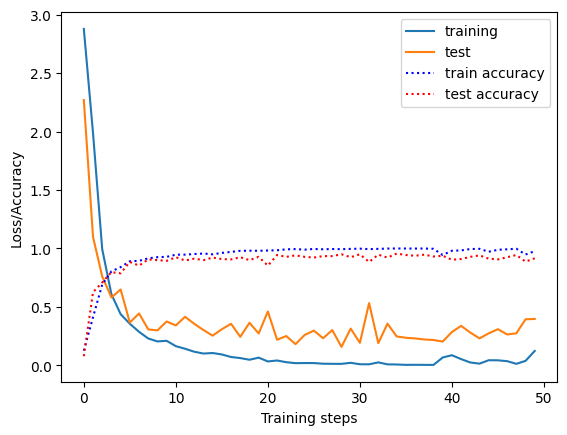

In [23]:
import matplotlib.pyplot as plt
#def visualization(train_lossses, train_accuracies, test_losses, test_accuracies):
plt.figure()
print(train_accuracies)
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(train_accuracies, "b:")
line4, = plt.plot(test_accuracies, "r:")
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3, line4),("training","test","train accuracy", "test accuracy"))
plt.show()

#2.1)
1. 70000 overall (10000 for test and 60000 for training)
2. 28,28,1 (Length, Width, Grayvalue)
3. 0-255 (0 = black/no intensity, 255 = white/full intensity)


#3.)
1. We can provoke overfitting by adding a lot of additional layers
2. The same applies when we train the model using too many epochs.
3. We can provoke underfitting by having not enough layers or nodes
4. The same applies when our learning rate is too high and our model converges too quickly
